# Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""
Change directory to where this file is located
"""
%cd /content/drive/MyDrive/데사원리와응용/

/content/drive/MyDrive/데사원리와응용


# Import Modules

In [3]:
import pathlib
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
"""
Import more if you want
"""
import os
from tensorflow import keras

In [5]:
"""
Make sure your runtime type is GPU!
"""
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Utils

In [6]:
def plot_dataset(images, labels, grid_width, grid_height, figure_width=5, figure_height=5, y_hats=None):
    """
    Plots image and labels.

    Do NOT modify this method.
    """
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = get_label_name(label_idx)
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(image, aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

def plot_history(history):
    """
    Plots training history.
    
    Do NOT modify this method.
    """
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# TF Flowers Dataset

### Load raw data

In [7]:
(raw_train_ds, raw_valid_ds, raw_test_ds), info = tfds.load('tf_flowers',
                                                            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
                                                            data_dir = './',
                                                            with_info=True, 
                                                            as_supervised=True)
num_classes = info.features['label'].num_classes
label_names = info.features['label'].names
get_label_name = info.features['label'].int2str

### Preprocess images

In [8]:
def preprocess(ds, img_shape=(64, 64, 3)):
    """
    Resize the image to the given shape and apply normalization
    """
    resizer = preprocessing.Resizing(height=img_shape[0], width=img_shape[1])
    rescaler = preprocessing.Rescaling(1. / 255)
    def map_func(x):
        x = resizer(x)
        x = rescaler(x)
        return x
    return ds.map(lambda x, y: (map_func(x), y))

In [9]:
"""
Apply preprocess to TF datasets
"""
img_shape = (64, 64, 3)

train_ds_preprocessed = preprocess(raw_train_ds, img_shape)
valid_ds_preprocessed = preprocess(raw_valid_ds, img_shape)
test_ds_preprocessed = preprocess(raw_test_ds, img_shape)

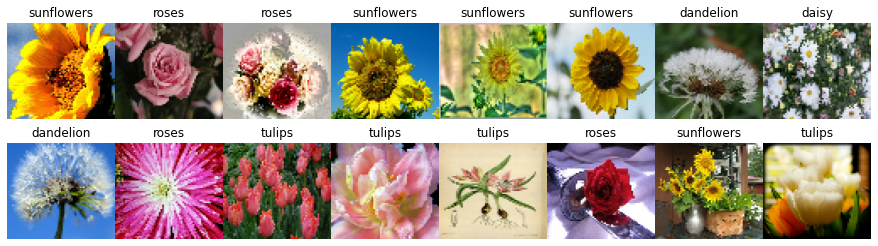

In [10]:
"""
Take a batch and plot images
"""
images, labels = next(iter(train_ds_preprocessed.shuffle(100).batch(16)))
plot_dataset(images, labels, grid_width=8, grid_height=2, figure_width=12, figure_height=3)

# Data Augmentation

In [11]:
###
# Question (a)
# Build your own augmentation layer.
# - use TF preprocessing layers to build an image augmentation layer.
# - use at least three methods.
# - for random cropping, you can combine it with resizing to preserve the image size(These will be counted as two methods)
# - for the supported methods, refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
###

In [12]:
augmentation_layer = tf.keras.Sequential(
    [
        preprocessing.RandomFlip(mode="horizontal_and_vertical"),
        preprocessing.RandomRotation(0.3),
        preprocessing.RandomTranslation(0.2, 0.2)
    ],
    name='augmentation_layers')

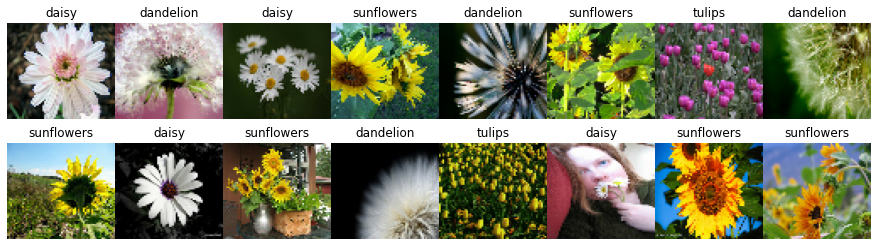

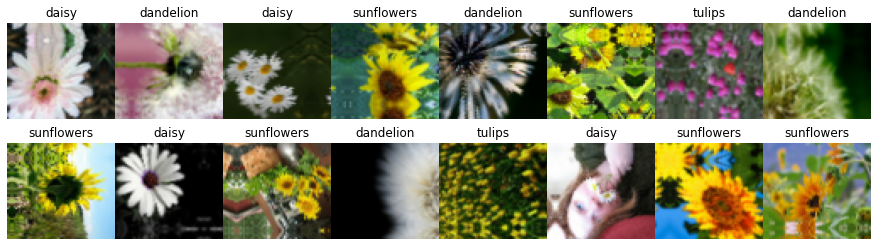

In [13]:
"""
Take a batch and plot augmented images
"""
images, labels = next(iter(train_ds_preprocessed.shuffle(100).batch(16)))
images_augmented = augmentation_layer(images)
plot_dataset(images, labels, grid_width=8, grid_height=2, figure_width=12, figure_height=3)
plot_dataset(images_augmented, labels, grid_width=8, grid_height=2, figure_width=12, figure_height=3)

# ConvNet

In [14]:
###
# Question (b)
# Use Tensorflow Sequential API to build a ConvNet.
# - don't forget to use InputLayer.
# - use your augmentation_layer implemented above.
# - use a Flatten layer before dense layers.
#
# - refer to the link below to see usages.
# - for the convolution layer, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# - for the pooling layer, https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
# - for the fully connected layer, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
# - refer to TF tutorials for further information.
###

In [15]:
model = tf.keras.Sequential([
    augmentation_layer,
    layers.Conv2D(8, 3, activation='tanh', padding='same', input_shape=(64, 64, 3)),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(16, 3, activation='tanh', padding='same'),
    layers.MaxPool2D(pool_size=(2,2), strides=2),
    layers.Conv2D(32, 3, activation='tanh', padding='same'),
    layers.MaxPool2D(pool_size=(2,2), strides=2),
    layers.Dropout(0.5, seed=123),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [16]:
###
# Question (c)
# Train your ConvNet to achieve TEST accuracy over 70%.
###

In [17]:
"""
Modify as you want
"""
batch_size = 64
epochs = 100

train_ds = train_ds_preprocessed.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds_preprocessed.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_preprocessed.batch(batch_size).prefetch(tf.data.AUTOTUNE)

tf.keras.backend.clear_session()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics='accuracy',
              run_eagerly=True)
logdir = os.path.join("./cnn_logs/")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.build((batch_size, 64, 64, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation_layers (Sequen  (None, 64, 64, 3)        0         
 tial)                                                           
                                                                 
 conv2d (Conv2D)             (64, 64, 64, 8)           224       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 32, 32, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 32, 32, 16)          1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 16, 16, 16)         0         
 2D)                                                             
                                                        

Epoch 1/100
46/46 [==============================] - 9s 145ms/step - loss: 1.3673 - accuracy: 0.3937 - val_loss: 1.3351 - val_accuracy: 0.4578
Epoch 2/100
46/46 [==============================] - 3s 70ms/step - loss: 1.2025 - accuracy: 0.5177 - val_loss: 1.2452 - val_accuracy: 0.5095
Epoch 3/100
46/46 [==============================] - 4s 74ms/step - loss: 1.1739 - accuracy: 0.5300 - val_loss: 1.3027 - val_accuracy: 0.4659
Epoch 4/100
46/46 [==============================] - 3s 69ms/step - loss: 1.0985 - accuracy: 0.5630 - val_loss: 1.2473 - val_accuracy: 0.5068
Epoch 5/100
46/46 [==============================] - 3s 68ms/step - loss: 1.0564 - accuracy: 0.5800 - val_loss: 1.1772 - val_accuracy: 0.5504
Epoch 6/100
46/46 [==============================] - 3s 70ms/step - loss: 1.0441 - accuracy: 0.5777 - val_loss: 1.2255 - val_accuracy: 0.5259
Epoch 7/100
46/46 [==============================] - 3s 71ms/step - loss: 1.0282 - accuracy: 0.5954 - val_loss: 1.1114 - val_accuracy: 0.5858
Epoch

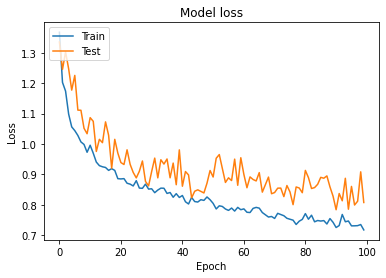

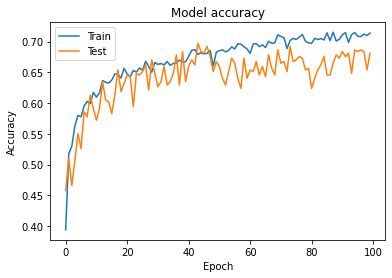

In [18]:
"""
Training
"""
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs)
plot_history(history)

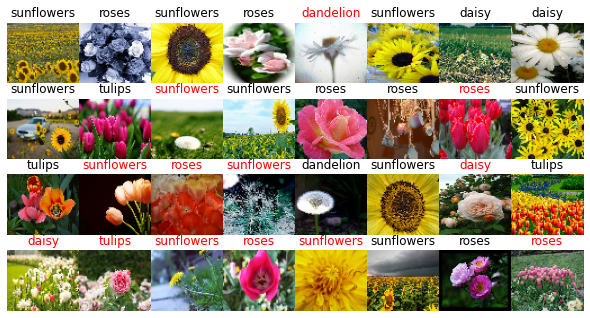

6/6 [==============================] - 0s 24ms/step - loss: 0.7450 - accuracy: 0.7057
Final test accuracy: 0.7057220935821533


In [19]:
"""
Evaluation
"""
images, labels = next(iter(test_ds_preprocessed.shuffle(500).batch(32).take(1)))
y_hats = np.argmax(model.predict(images), axis=1)
plot_dataset(images, labels, grid_width=8, grid_height=4, figure_width=8, figure_height=4, y_hats=y_hats)

test_loss, test_acc = model.evaluate(test_ds)
print('Final test accuracy: {}'.format(test_acc))